In [1]:
# Auto Reload
%load_ext autoreload
%autoreload 2

In [48]:
# Import Modules
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
from pprint import pprint
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from math import log
import re
from gensim import corpora
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from urllib.parse import urljoin
from urllib.parse import urlparse

from wordcloud import WordCloud

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# NLTK Modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import chunk
from nltk.util import ngrams

# Import Custom Modules
from src.data_cleaner import *
from src.dummy_words import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [3]:
# Use lyricsgenius module
import lyricsgenius as genius
# Import Credentials
from src.credentials.keys import *

# Scrape web to get Kodak Black lyrics

In [4]:
# # Set Target Artist
# trg_artist = 'Kodak Black'
# # Create API Instance
# api = genius.Genius(client_token)
# # Search Artist Information
# artist = api.search_artist(trg_artist)

In [5]:
# Save Lyrics from Artist
# aux = artist.save_lyrics(filename='lyrics.json', overwrite=True, verbose=True)

In [6]:
# Read in recently created JSON
titles = None
with open('data/lyrics.json') as jsonfile:
    data = json.load(jsonfile)
    songs = data['songs']  

In [7]:
# Get Title of songs
titles = [song['title'] for song in songs]

In [8]:
# Get Lyrics from each song
lyrics = [song['lyrics'] for song in songs]

# Taking a look at what a single song looks like (truncated)
lyrics[0][:300]

'[Intro]\nGlee\nSouthside\nAyy, lil\' Metro on that beat\n\n[Chorus]\nLil\' Kodak, they don\'t like to see you winnin\'\nThey wanna see you in the penitentiary\nI need me a lil\' baby who gon\' listen\nGirl, I don\'t wanna be the one you iggin\'\nMy mama told me, "Boy, make good decisions"\nRight now I gotta keep a tun'

# Cleaning Lyrics

> Remove headers from each lyric set and standardize casing

In [9]:
# Use custom function to remove headers from each set of lyrics
clean_lyrics = [remove_headers(lyric).lower() for lyric in lyrics]
clean_lyrics[0][:300]

'\nglee\nsouthside\nayy, lil\' metro on that beat\n\nlil\' kodak, they don\'t like to see you winnin\'\nthey wanna see you in the penitentiary\ni need me a lil\' baby who gon\' listen\ngirl, i don\'t wanna be the one you iggin\'\nmy mama told me, "boy, make good decisions"\nright now i gotta keep a tunnel vision\ni nee'

> Remove new-line breaks and escapes

In [10]:
# Replace new-line breaks and escape characters
clean_lyrics = [lyric.replace('\n', ' ') for lyric in clean_lyrics]
clean_lyrics = [lyric.replace('\'', '') for lyric in clean_lyrics]

clean_lyrics[0]

' glee southside ayy, lil metro on that beat  lil kodak, they dont like to see you winnin they wanna see you in the penitentiary i need me a lil baby who gon listen girl, i dont wanna be the one you iggin my mama told me, "boy, make good decisions" right now i gotta keep a tunnel vision i need me a lil baby who gon listen girl, i dont wanna be the one you iggin lil kodak, they dont like to see you winnin they wanna see you in the penitentiary i need me a lil baby who gon listen girl, i dont wanna be the one you iggin my mama told me, "boy, make good decisions" right now i gotta keep a tunnel vision they sendin all my homies on a mission and i aint tryna miss out on these millions  i jumped up out the wraith, kodak bought a wraith i get any girl i want, any girl i want she want me to save the day, but i aint got a cape she wanna see me every day, she wanna be my bae that money make me cum, it make me fornicate, uh im the shit, i need some toilet pap-er follow my player rules, then we go

> Tokenize words manually (NLTK proven uneffective)

In [11]:
# Tokenize Words
tokens = [lyric.split() for lyric in clean_lyrics]
tokens = [[re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem) for elem in token] for token in tokens]
tokens = [[word for word in token if word] for token in tokens]
tokens[0][:10]

['glee',
 'southside',
 'ayy',
 'lil',
 'metro',
 'on',
 'that',
 'beat',
 'lil',
 'kodak']

> Remove Stop Words

In [12]:
# Remove Stop Words
stop_words = set(stopwords.words('english'))
tokens = [[word for word in token if word not in stop_words] for token in tokens] 
tokens[0][:10]

['glee',
 'southside',
 'ayy',
 'lil',
 'metro',
 'beat',
 'lil',
 'kodak',
 'dont',
 'like']

# Looking into Stemming or Lemmatization

In [13]:
first_song = list(set(tokens[0]))
# Create Porter, Snowball, WordNet Objects
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

# Get functions from each object
porter_func = porter.stem
snowball_func = snowball.stem
wordnet_func = wordnet.lemmatize

# Create lambda func to easily apply func to each token
get_root = lambda tokens, func: [func(token) for token in tokens] 

# Get Tokens for each type of processor
porter_tokens = list(map(porter_func, first_song))
snowball_tokens = list(map(snowball_func, first_song)) 
wordnet_tokens = list(map(wordnet_func, first_song)) 

In [14]:
## Print the stemmed and lemmatized words from the target document
print("%16s | %16s | %16s | %16s |" % ("WORD", "PORTER", "SNOWBALL", "LEMMATIZER"))
for i in range(min(len(porter_tokens), len(snowball_tokens), len(wordnet_tokens))):
    p, s, w = porter_tokens[i], snowball_tokens[i], wordnet_tokens[i]
    if len(set((p, s, w))) != 1:
        print("%16s | %16s | %16s | %16s |" % (first_song[i], p, s, w))

            WORD |           PORTER |         SNOWBALL |       LEMMATIZER |
    penitentiary |     penitentiari |     penitentiari |     penitentiary |
            baby |             babi |             babi |             baby |
         codeine |           codein |           codein |          codeine |
           cause |             caus |             caus |            cause |
          homies |             homi |             homi |           homies |
       cooperate |           cooper |           cooper |        cooperate |
       fornicate |           fornic |           fornic |        fornicate |
          booted |             boot |             boot |           booted |
           horny |            horni |            horni |            horny |
           every |            everi |            everi |            every |
      everything |          everyth |          everyth |       everything |
             ayy |              ayi |              ayi |              ayy |
          ju

# DOC2VEC

In [15]:
# Create Doc2Vec Model
dv_model = Doc2Vec(
    alpha=0.025,
    min_alpha=0.025,
    workers=15, 
    min_count=2,
    window=10,
    vector_size=300,
    epochs=20,
    sample=0.001,
    negative=5
)

- ***alpha*** is the initial learning rate. A very intuitive explanation for learning rate can be found here. Essentially, the learning rate is, as stated in the link, "how quickly a network abandons old beliefs for new ones."
- ***min_alpha*** is exactly what it sounds like, the minimum alpha can be, which we reduce after every epoch.
- ***workers*** is the number of threads used to train the model.
- ***min_count*** specifies a term frequency that must be met for a word to be considered by the model.
- ***window*** is how many words in front and behind the input word should be considered when determining context.
- ***size*** is the number of dimensions. Unlike most numerical datasets that have 2 dimensions, text data can have hundreds or even more.
- ***iter*** is the number of iterations, the number of times the training set passes through the algorithm.
- ***sample*** is the downsampling rate. Words representing more than this will be eligible for downsampling.
- ***negative*** is the negative sampling rate. 0 means update all weights in the output layer of the neural network.

### Creating Sentences via TaggedDocument


In [16]:
# Create TaggedDocument objects with song tokens and tag (song number)
sentences = [TaggedDocument(
             words=document,
             tags=['%s | %s' % (i, titles[i])]) 
             for i, document in enumerate(tokens)]
# sentences[0]

#### Model Training and Vocab Building

In [17]:
# Build Model Vocab
dv_model.build_vocab(sentences)

In [18]:
# Train Model
epochs = 10
for epoch in range(epochs):
    dv_model.train(sentences, total_examples=dv_model.corpus_count, epochs=dv_model.epochs)
    dv_model.alpha -= 0.002  # decrease the learning rate
    dv_model.min_alpha = dv_model.alpha  # fix the learning rate, no decay

## Checkpoint Model

In [20]:
dv_model.save('data/kodak_lyrics.doc2vec')

In [22]:
# Load Model to Test Save
dv_model = Doc2Vec.load('data/kodak_lyrics.doc2vec')

### Looking at word similarity and association

In [37]:
# House
dv_model.wv.most_similar('house')

[('arrest', 0.3720146715641022),
 ('found', 0.3172382712364197),
 ('infinity', 0.29102620482444763),
 ('price', 0.2906968593597412),
 ('paid', 0.28518110513687134),
 ('dip', 0.264195054769516),
 ('thots', 0.2627524733543396),
 ('winter', 0.25071802735328674),
 ('manuvering', 0.2504286766052246),
 ('gone', 0.2497052550315857)]

In [56]:
# Coupe
dv_model.wv.most_similar('coupe')

[('whip', 0.28635820746421814),
 ('anyways', 0.2713841199874878),
 ('booger', 0.25949209928512573),
 ('woo', 0.2574138641357422),
 ('tiger', 0.23631080985069275),
 ('protest', 0.23347043991088867),
 ('soo', 0.2253037691116333),
 ('legendary', 0.2240905463695526),
 ('qp', 0.22198450565338135),
 ('fruit', 0.22125600278377533)]

# LDA to find Kodak Black Topics

In [71]:
# Filter Expletives and Kodak Specific Stop Words
stops = ['im', 'thats', 'ya', 'though', 'yeah', 'ayy', 'got', 'ima', 'like']
tokens = list(map(lambda x: [match_dummies(y) for y in x if y not in stops], tokens))

In [72]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform([" ".join(token) for token in tokens])

# Tweak the two parameters below (use int values below 15)
number_topics = 7
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [73]:
# Print the topics found by the LDA model
print("Kodak Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Kodak Topics found via LDA:

Topic #0:
expletive_0 aint dont lil expletive_4 know cause expletive_3 damn say boy yea kodak baby expletive_1

Topic #1:
expletive_0 aint dont know expletive_4 cause bout expletive_3 need man lil gon streets couldve goin

Topic #2:
wanna expletive_3 aint money feel lets expletive_0 dont need lil moshpit baby cause new start

Topic #3:
expletive_0 aint dont wanna know expletive_4 expletive_3 want love money say cause hit expletive_1 lil

Topic #4:
aint dont expletive_0 expletive_3 cause baby know lil time expletive_4 love need expletive_1 wanna want

Topic #5:
expletive_0 aint know dont expletive_4 money baby expletive_1 expletive_3 boy lil kodak gotta gon tryna

Topic #6:
everybody wanna ride die aint 1k lil tryna expletive_0 gotta candy know need expletive_4 stay


# Kodak Word Cloud

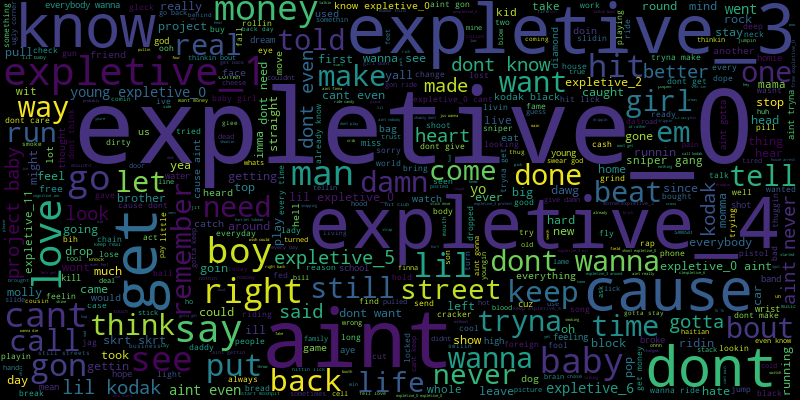

In [74]:
# Join the different processed titles together
long_string = ','.join([",".join(token) for token in tokens])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# Kodak Common Words

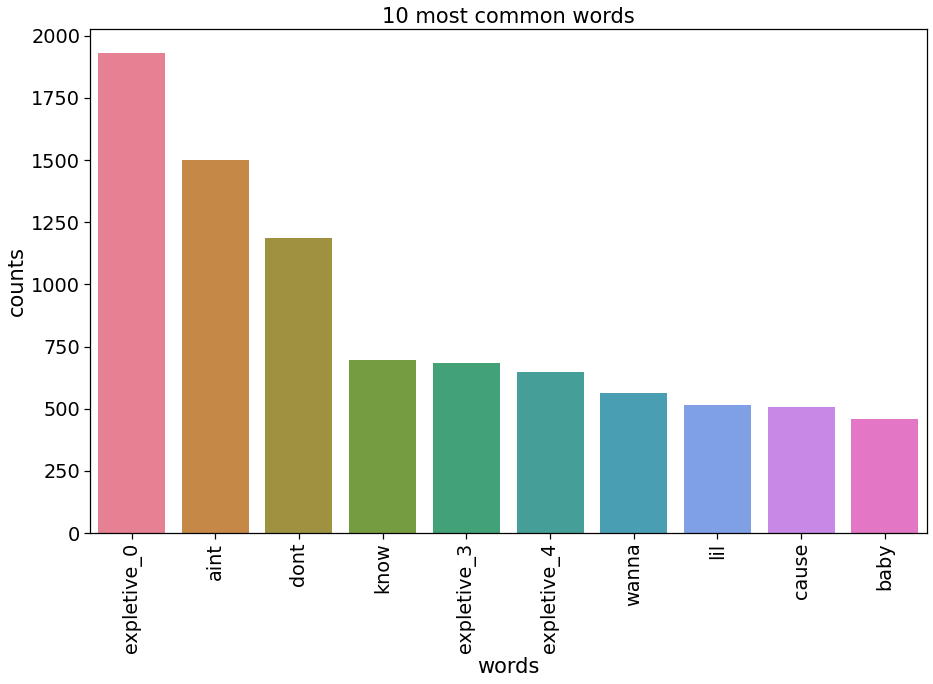

In [75]:
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)